<a href="https://colab.research.google.com/github/JohnNun/pneumonia_identification_project/blob/main/pneumonia_identification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Identification Project

Pneumonia remains a global health concern, particularly affecting young children, the elderly, and individuals with compromised immune systems. Despite advancements in medicine and science, pneumonia continues to be a leading cause of death accounting for approximately 2.18 million deaths globally in 2021, with the highest impact observed among children under five and adults over 70. While most cases can be treated, early detection in patients can further improve treatment success rate. Through the use of a convolutional neural network model (CNN) and pediatric chest X-ray images, I created a machine learning model with the capability to detect and predict if a patient has pneumonia.

The dataset used for this model was compiled by [Kaggle](https://www.kaggle.com/) and is made up of 5,863 chest X-ray images sourced from pediatric patients ranging between one to five years of age. The data is categorized into two classes, “Normal” and “Pneumonia”. The Data preprocessing involved data augmentation when importing images to lessen model bias and improve generalization as well as data normalization to improve data computation.

For the model construction I used the TensorFlow and Keras libraries, using the sequential module structure for simplicity and organization. Due to the heavy class imbalance of 4,506 “pneumonia” images and 1,350 “normal” images, I use methods such as dropout and L2 kernel regularizers to reduce overfitting during the model creation. I also use early stop to stop model training if the validation score increased rather than decreased.

Among the models created model 5 performed the best overall, with a test data accuracy of 80%. However, the model does have a loss of 0.60, meaning there is still room for improvement. Among other metric results, the model’s precision results in a .92 with “normal” classes and .76 for “pneumonia”. Recall on the other hand shows high sensitivity to “pneumonia” with .97 but a low performance of .48 with the “normal” class.

# Business and Data Understanding


According to the [World Health Organization](https://www.who.int/health-topics/pneumonia/#tab=tab_1), pneumonia is an acute respiratory infection that inflames the air sacs (alveoli) in one or both lungs. It can be caused by bacteria, viruses, or fungi making breathing difficult and reducing oxygen intake. It affects people of all ages but is especially dangerous for young children, older adults, and people with weakened immune systems. Despite the advances in science and medicine, pneumonia remains a major cause of mortality worldwide. In 2021, Pneumonia caused 2.18 million deaths globally, mainly in children younger than 5 years and adults over 70 years, and in those who are susceptible [The Lancet](https://www.thelancet.com/journals/lanres/article/PIIS2213-2600(25)00087-6/fulltext?utm_source). With the development and use of an image classification neural network learning algorithm, it may be possible to detect pneumonia in young children and elderly adults in its early stages possibly leading to prompt treatment.

The data used for this project was retrieved from [Kaggle datasets Chest X-Ray Images](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) this dataset is comprised of 5863 x-ray images divided between two classes, “Normal”, and “Pneumonia”. The chest X-ray images in the dataset were selected from pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center.

# Data preparation

For data preparation, I first used ImageDataGenerator tool to import all data. I used this tool because it would allow me to add random data augmentation parameters such as flips, set a brightness range, etc. to the training data as its being imported, essentially creating synthetic data and implementing a way to help lower model bias. In the total data, there are 4506 images of pneumonia positive images while there are only 1350 images of pneumonia negative meaning that the data is heavily weighted towards pneumonia positive and as such can lead to severe model bias.

After I've imported the data, I created a separate variable with reshaped data, essentially un-rowing the data to fit the model structural requirements of multiplying the image dimensions and image RGB layers (256 * 256 * 3). To complete my data preparations, I normalize the data bringing the data to a 0 to 1 scale to ensure all features are on a similar scale and improve data computation. I created two sets of normalized data, one with the reshaped data and the other with the original data as CNN models only take in image dimensions.

In [ ]:
# For Google Colab only
# Cell output cleared as it only contains installation progress information
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]

In [ ]:
# Importing tools and modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
# Linking directory path
train_data_dir = 'drive/MyDrive/chest_xray/train'
val_data_dir = 'drive/MyDrive/chest_xray/val'

In [ ]:
# Variable to add random data augmentations when importing
datagen = ImageDataGenerator(horizontal_flip=True,
                             brightness_range=[.5, 1]
                            )

In [ ]:
# Getting train, test, and validation data from directory
train_generator = datagen.flow_from_directory(train_data_dir, target_size=(256, 256), batch_size=2000, seed=42)
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir, target_size=(256, 256), batch_size=232)

Found 5000 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


In [ ]:
# Creating datasets (may take up to 15 minutes on initial run)
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)

In [ ]:
# Reshaping data
train_img_unrow = train_images.reshape(2000,-1)
val_img_unrow = val_images.reshape(232,-1)

In [ ]:
# Checking data shape
print(np.shape(train_img_unrow))
print(np.shape(val_img_unrow))

(2000, 196608)
(232, 196608)


In [ ]:
# Normalizing data
train_img_norm, val_img_norm = train_images / 255.0, val_images / 255.0

In [ ]:
# Normalizing reshaped data
train_img_final, val_img_final  = train_img_unrow/ 255.0, val_img_unrow/ 255.0

# Modeling

For the image classification neural network model, I imported tools and libraries from Tensorflow primarily Keras tools. To build the models I used the Sequential module due to its simplicity input to output linear stack model structure. To help with model tuning, I used an early stop method to track the model’s validation loss and stop the model if the validation loss no longer decreased or if it increased consecutively. As for the models learning rate I went with Adaptive Moment Estimation (Adam), as this optimizer uses momentum and RMSprop to automatically adjust the models learning rate.

Due to the data’s heavy class imbalance, the model would often overfit, so to lower overfitting as best as possible I implemented dropout layers to randomly drop nodes in the model. Another method I used to lower overfitting was adding L2 kernel regularizers so to penalize the excessive pneumonia weight from the class imbalance.

In [ ]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [ ]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [ ]:
# Creating dictionary for train, test, validation data
data_dict = {
    'Train Data': (train_img_norm, train_labels),
    'Val Data': (val_img_norm, val_labels)
}

In [ ]:
# Creating dictionary for normalized train, test, validation data
data_dict_norm = {
    'Train Data': (train_img_final, train_labels),
    'Val Data': (val_img_final, val_labels)
}

### Model 1

In [ ]:
model_1 = Sequential()

In [ ]:
model_1.add(layers.Input(shape=(196608,)))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

In [ ]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_1_results = model_1.fit(train_img_final, train_labels,
                              epochs=10,
                              batch_size=125,
                              validation_data=(val_img_final, val_labels))

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.7376 - loss: 8.1081 - val_accuracy: 0.5000 - val_loss: 1.1987
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7801 - loss: 0.4750 - val_accuracy: 0.6724 - val_loss: 0.5771
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8644 - loss: 0.3463 - val_accuracy: 0.8017 - val_loss: 0.4146
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8905 - loss: 0.2989 - val_accuracy: 0.8362 - val_loss: 0.3693
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9020 - loss: 0.2650 - val_accuracy: 0.7026 - val_loss: 0.6784
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8866 - loss: 0.2696 - val_accuracy: 0.8319 - val_loss: 0.4140
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9177 - loss: 0.2137 - val_accuracy: 0.8664 - val_loss: 0.3043
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9303 - loss: 0.1942 - val_accuracy: 0.8621 - 

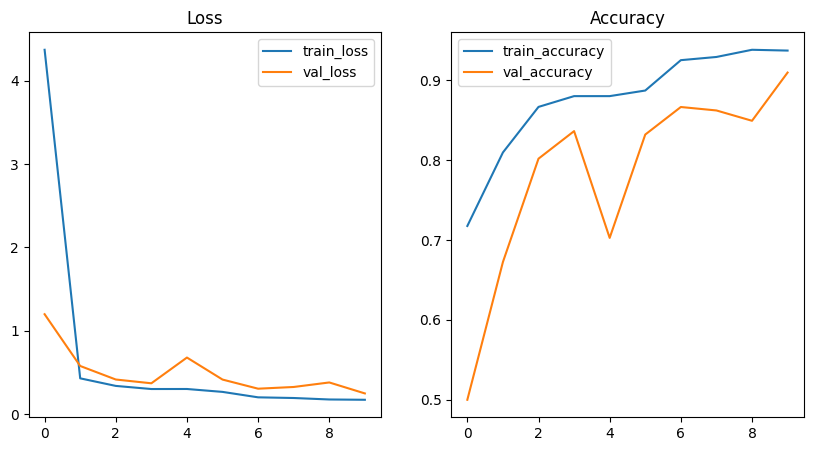

In [ ]:
plot_results([model_1_results])

In [ ]:
model_evaluation(model_1, data_dict_norm)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9341 - loss: 0.1962
Train Data, Loss: 0.2065, Accuracy: 0.9230
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9052 - loss: 0.2494
Val Data, Loss: 0.2476, Accuracy: 0.9095


### Model 2

In [ ]:
model_2 = Sequential()

In [ ]:
model_2.add(layers.Input(shape=(196608,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.5)))
model_2.add(Dropout(0.5))
model_2.add(Dense(25, activation='relu'))
model_2.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_2.add(Dropout(0.2))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dense(2, activation='softmax'))

In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Creating early stop callback variable
early_stop = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=5, mode='min', restore_best_weights=True)

In [ ]:
model_2_results = model_2.fit(train_img_final, train_labels,
                              epochs=25,
                              batch_size=300,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[early_stop])

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6292 - loss: 34.5845 - val_accuracy: 0.5000 - val_loss: 32.6861
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6149 - loss: 31.6630 - val_accuracy: 0.5000 - val_loss: 29.5456
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6649 - loss: 28.7061 - val_accuracy: 0.5862 - val_loss: 26.8119
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6035 - loss: 26.6977 - val_accuracy: 0.7543 - val_loss: 24.9902
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7241 - loss: 24.6171 - val_accuracy: 0.7241 - val_loss: 23.3312
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7158 - loss: 22.9111 - val_accuracy: 0.6940 - val_loss: 21.8081
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7923 - loss: 21.2570 - val_accuracy: 0.7672 - val_loss: 20.2419
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7878 - loss: 19.8106 - val_accuracy: 0.7974 - val

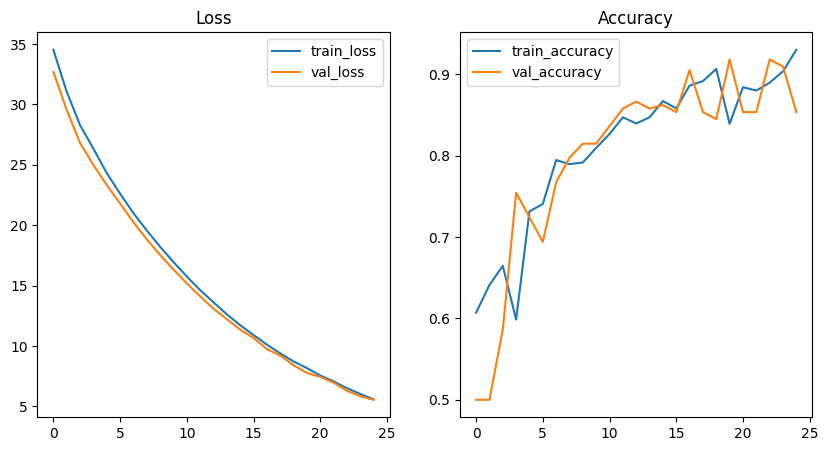

In [ ]:
plot_results([model_2_results])

In [ ]:
model_evaluation(model_2, data_dict_norm)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9513 - loss: 5.3096
Train Data, Loss: 5.3026, Accuracy: 0.9475
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.8666 - loss: 5.5517
Val Data, Loss: 5.5532, Accuracy: 0.8534


### Model 3

In [ ]:
model_3 = Sequential()

In [ ]:
model_3.add(layers.Input(shape=(196608,)))
model_3.add(Dense(75, activation='relu'))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.0005)))
model_3.add(Dense(25, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.025)))
model_3.add(Dense(10, activation='relu', kernel_regularizer=l2(l2=0.01)))
model_3.add(Dense(2, activation='softmax'))

In [ ]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Creating reduce learning rate callback variable
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max')

In [ ]:
model_3_results = model_3.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=300,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[early_stop, reduce_lr])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.6799 - loss: 3.2676 - val_accuracy: 0.5000 - val_loss: 3.2940 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6864 - loss: 1.9577 - val_accuracy: 0.5000 - val_loss: 2.0114 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6689 - loss: 1.4524 - val_accuracy: 0.5000 - val_loss: 1.4684 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6595 - loss: 1.3601 - val_accuracy: 0.5647 - val_loss: 1.3721 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7047 - loss: 1.3020 - val_accuracy: 0.5948 - val_loss: 1.3248 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7097 - loss: 1.2774 - val_accuracy: 0.5086 - val_loss: 1.3465 - learning_rate: 5.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7110 - loss: 1.2638 - val_accura

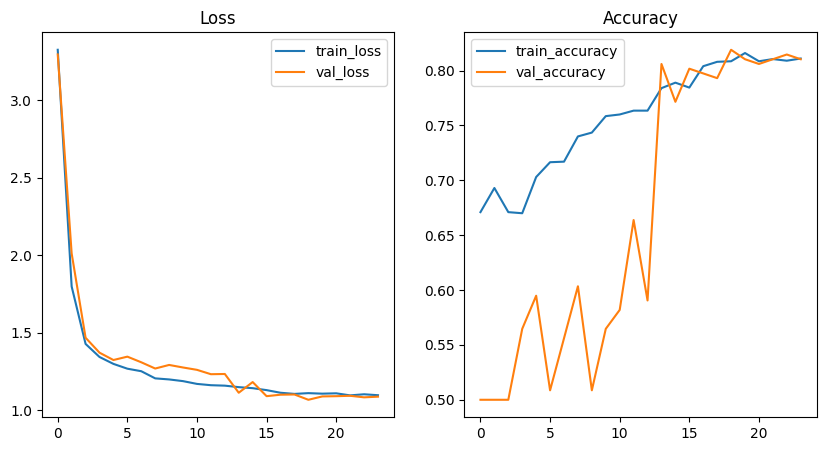

In [ ]:
plot_results([model_3_results])

In [ ]:
model_evaluation(model_3, data_dict_norm)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8964 - loss: 0.9767
Train Data, Loss: 0.9761, Accuracy: 0.8995
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.8336 - loss: 1.0571
Val Data, Loss: 1.0686, Accuracy: 0.8190


### Model 4

In [ ]:
model_4 = Sequential()

In [ ]:
model_4.add(layers.Input(shape=(256, 256, 3)))
model_4.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model_4.add(layers.MaxPooling2D())

model_4.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model_4.add(layers.MaxPooling2D())

model_4.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dense(2, activation='softmax'))

In [ ]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_4_results = model_4.fit(train_img_norm, train_labels,
                              epochs=15, batch_size=200,
                              validation_data=(val_img_norm, val_labels),
                              callbacks=[early_stop]
                              )

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 524ms/step - accuracy: 0.5189 - loss: 2.0101 - val_accuracy: 0.5000 - val_loss: 1.1077
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7353 - loss: 0.5835 - val_accuracy: 0.5000 - val_loss: 0.9237
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7441 - loss: 0.4499 - val_accuracy: 0.5000 - val_loss: 0.8145
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7442 - loss: 0.3579 - val_accuracy: 0.5000 - val_loss: 0.7206
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7633 - loss: 0.3037 - val_accuracy: 0.7198 - val_loss: 0.7104
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9136 - loss: 0.2731 - val_accuracy: 0.7586 - val_loss: 0.6721
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9266 - loss: 0.2462 - val_accuracy: 0.8836 - val_loss: 0.4473
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9534 - loss: 0.2392 - val_accuracy: 0.8147

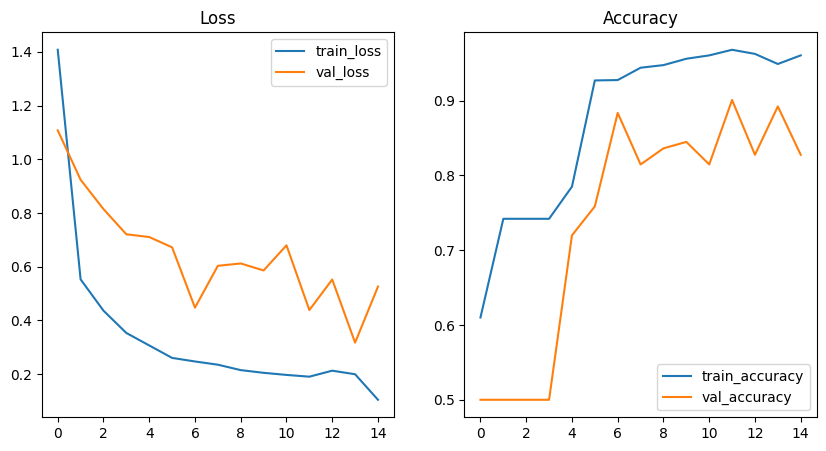

In [ ]:
plot_results([model_4_results])

In [ ]:
model_evaluation(model_4, data_dict)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9784 - loss: 0.1027
Train Data, Loss: 0.1023, Accuracy: 0.9780
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8983 - loss: 0.3459
Val Data, Loss: 0.3172, Accuracy: 0.8922


### Model 5

In [ ]:
model_5 = Sequential()

In [ ]:
model_5.add(layers.Input(shape=(256, 256, 3)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Conv2D(32, kernel_size=(5,5), activation='relu', padding='valid', kernel_regularizer=l2(l2=0.09)))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid'))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid'))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=l2(l2=0.03)))
model_5.add(layers.Dropout(0.25))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Flatten())
model_5.add(layers.Dense(32, activation='relu'))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(l2=0.01)))
model_5.add(layers.Dense(2, activation='softmax'))

In [ ]:
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_5_results = model_5.fit(train_img_norm, train_labels,
                              epochs=35, batch_size=125,
                              validation_data=(val_img_norm, val_labels),
                              callbacks=[early_stop],
                              verbose=2)

Epoch 1/35
16/16 - 22s - 1s/step - accuracy: 0.5755 - loss: 2.7343 - val_accuracy: 0.5000 - val_loss: 2.2221
Epoch 2/35
16/16 - 1s - 77ms/step - accuracy: 0.7030 - loss: 1.7682 - val_accuracy: 0.5000 - val_loss: 1.5401
Epoch 3/35
16/16 - 1s - 75ms/step - accuracy: 0.7775 - loss: 1.1341 - val_accuracy: 0.5000 - val_loss: 1.1965
Epoch 4/35
16/16 - 1s - 75ms/step - accuracy: 0.7800 - loss: 0.7673 - val_accuracy: 0.5000 - val_loss: 0.9314
Epoch 5/35
16/16 - 1s - 76ms/step - accuracy: 0.7945 - loss: 0.5977 - val_accuracy: 0.5000 - val_loss: 1.0376
Epoch 6/35
16/16 - 1s - 76ms/step - accuracy: 0.8135 - loss: 0.5064 - val_accuracy: 0.5000 - val_loss: 0.7743
Epoch 7/35
16/16 - 1s - 75ms/step - accuracy: 0.8160 - loss: 0.4550 - val_accuracy: 0.5000 - val_loss: 0.7091
Epoch 8/35
16/16 - 1s - 75ms/step - accuracy: 0.8315 - loss: 0.4025 - val_accuracy: 0.5388 - val_loss: 0.6615
Epoch 9/35
16/16 - 1s - 75ms/step - accuracy: 0.8310 - loss: 0.3837 - val_accuracy: 0.7241 - val_loss: 0.6321
Epoch 10/35

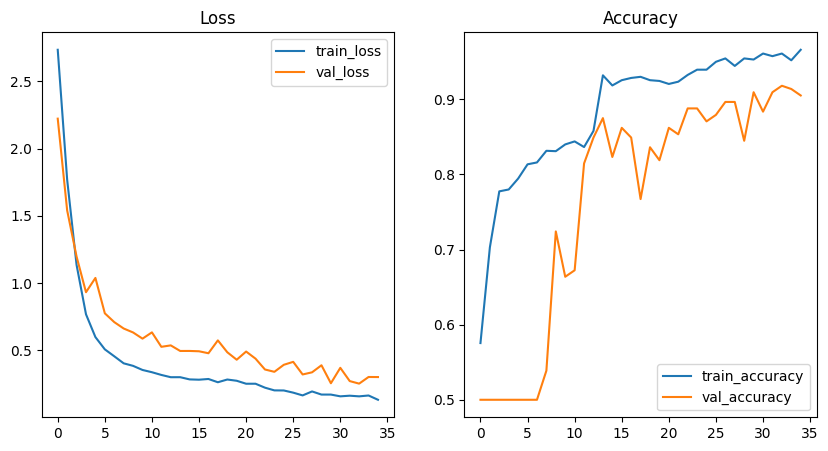

In [ ]:
plot_results([model_5_results])

In [ ]:
model_evaluation(model_5, data_dict)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9459 - loss: 0.2149
Train Data, Loss: 0.2222, Accuracy: 0.9355
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9086 - loss: 0.2665
Val Data, Loss: 0.2515, Accuracy: 0.9181


# Evaluation

The model that performed the best overall and will be the final model is model 5, the Convolutional Neural Network. Although this model has a rough start, it quickly corrects and starts to learn from the data leading the model to generalize better resulting in quickly lowering train and validation loss, and increasing accuracy for training and validation data.

When evaluating the final model with the test data, this model has an accuracy of 84% but a loss of 0.54, so while the model is confident with its prediction it appears to be correct about half of the time. When it comes to the model’s precision it resulted with 0.86 when it came to identifying normal class, and .83 for the pneumonia class. For the models recall when identifying the normal class, it resulted in .69, while for the pneumonia class the results were significantly higher with a .93 as the data is heavily weighted towards the pneumonia class. Overall, the final model performs well with an 84% accuracy despite the class imbalance and the loss of .54, but with further tuning or a more balanced dataset I’m sure the model can improve.

In [ ]:
# Connecting test data Directory
test_data_dir = 'drive/MyDrive/chest_xray/test'

In [ ]:
# Importing test data
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(256, 256), batch_size=624)

Found 624 images belonging to 2 classes.


In [ ]:
# Creating test data dataset
test_images, test_labels = next(test_generator)

In [ ]:
# Normalizing test data
test_img_norm = test_images / 255.0

###Final Model

In [ ]:
# Creating final model variable
final_model = model_5

In [ ]:
final_model.evaluate(test_img_norm, test_labels)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8247 - loss: 0.5758


[0.5482506155967712, 0.8413461446762085]

In [ ]:
# Getting test data pedictions
test_img_pred = final_model.predict(test_img_norm)

# Converting test_img_pred and test_labels to single-label format
test_img_pred_labels = np.argmax(test_img_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Classification report
print(classification_report(test_true_labels, test_img_pred_labels))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
              precision    recall  f1-score   support

           0       0.86      0.69      0.77       234
           1       0.83      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.81      0.82       624
weighted avg       0.84      0.84      0.84       624



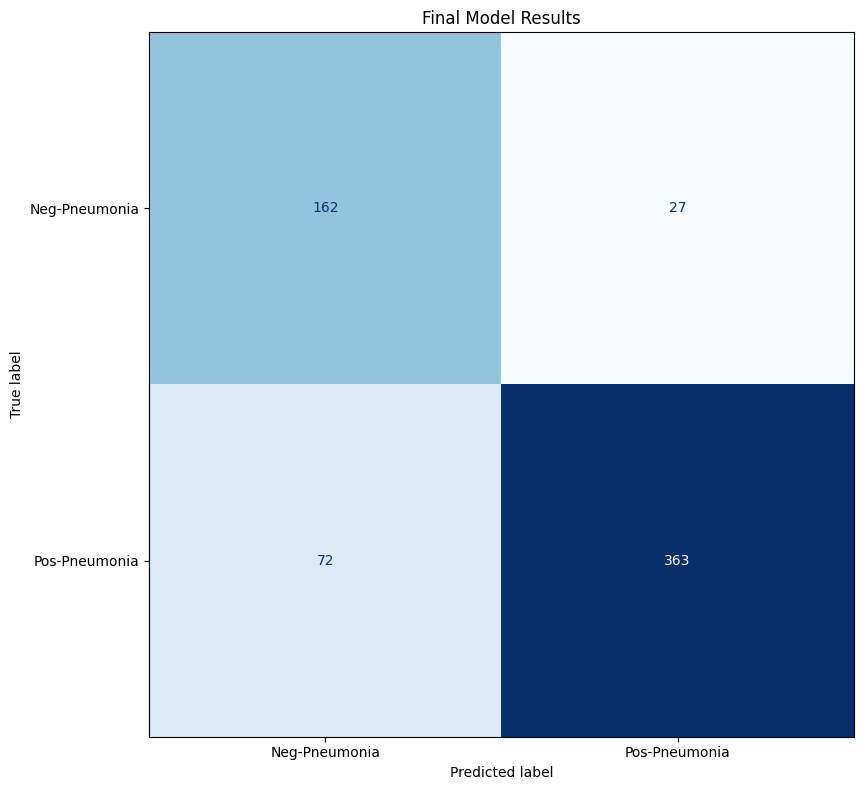

In [ ]:
# Plotting Confusion Matrix of final Model
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title('Final Model Results')

cm = confusion_matrix(test_img_pred_labels, test_true_labels)

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=['Neg-Pneumonia', 'Pos-Pneumonia']).plot(ax=ax, cmap='Blues', colorbar=False)

plt.tight_layout();

# Limitations

A limitation I encountered in this project is the data itself and how heavily weighted it is towards pneumonia positive. While there are methods that can help alleviate the class weight imbalance and maybe even lessen model bias through the creation of synthetic data, synthetic data generated from these methods isn't as reliable as real data.

The data gathered from Kaggle datasets while great, it does come already split between train, test, and validation data essentially giving little control over how the data can be divided unless using outside sources or manually moving data.

# Next Steps

For some next steps, further model tweaks and parameter tuning may be necessary to improve the model’s overall performance. While 84% is not terrible for accuracy with unseen test data, it does leave a little more to be desired especially with a loss of .54 this tells us the model is missing the mark a little more than half of the time.

Another potential next step if time permits would be using other Convolutional neural networks such as ResNet, DenseNet or ViT (Vision Transformers) image classification algorithms and comparing results to the current final model as the base model.

Lastly, the next step I believe can be greatly beneficial to the overall project is gathering more data, especially gathering more x-ray images of healthy pneumonia free lungs. As stated before the data's class weights are heavily weighted towards pneumonia positive which can lead to model bias.